---
title: "Buy vs. Rent, A Financial Modeling Workflow in Python"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2022-8-6"
description: "Using `numpy-financial` and monte-carlo simulation to evaluate investments."
draft: false
categories:  ['Python', 'Probability']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

In [728]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Problem Setup


In [150]:
# Buying Constants
interest_rate = 0.065
cost = 875000
hoa = 0
renovation = 100000
principal = cost - cost * .2
buying_fees = principal*.04

# Renting Constants
rent = 3500
rent_growth = 1.015

### Definining Constants
I'll run this as a comparison between buying an apartment that costs $<b></b>700,000 with a 20% downpayment, versus renting a home for \$2,600 a month. This is meant to approximate buying versus renting a two-bed one-bath apartment.  

Buying fees are defined at 4%, the homeowners association fees are defined as \$700 monthly.

`npf.pmt()` can be used to generate a monthly mortgage payment given those buying constants:


In [151]:
npf.pmt(interest_rate/12, 12*30, principal)

-4424.476164450758

alternatively, we can use `npf.ppt()` to see how much of the payment goes towards the principal, and use `npf.ipmt()` to see how much goes towards interest (see below for applications of those functions).

### Defining Random Variables
I'll make the simplifying assumption that both "annual home appreciation" and "annual stock appreciation" are generated from normal distributions. This is a kind of strong assumption, but one that seems to be routinely made at least with regards to stock market returns, even if there might be better distribution choices out there ([more here](https://arxiv.org/ftp/arxiv/papers/1906/1906.10325.pdf)). 

Here's a look at how we'll draw from a normal distribution. Given an average annual return, $\mu = 0.0572$ ($\mu$, or, mu, is a common variable name for average) and a standard deviation $\sigma = 0.1042$ ($\sigma$, or, sigma, is the common variable name for standard deviation), we can draw one sample from a normal distribution as follows:


In [152]:
# Set a random seed for stability of results
np.random.seed(30)

mean = .0572
standard_deviation = .1042
samples = 1

# Draw the sample
np.random.normal(mean, standard_deviation, samples)

array([-0.07451429])

We now simulate market returns for every month by supplying mean and standard deviation values for both home and stock market appreciation and drawing 360 samples (360 months in 30 years). For simplicity, we'll just use world-wide aggregate values from ["The Rate of Return on Everything, 1870-2015"](https://www.frbsf.org/economic-research/wp-content/uploads/sites/4/wp2017-25.pdf).


In [153]:
mu_stock = .1081
sigma_stock = .2267

mu_home = .0572
sigma_home = .1042

Given that stock and home appreciation is probably correlated, I'll have ti sample from a bivariate normal distribution using `numpy.random.Generator.multivariate_normal` - documentation [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multivariate_normal.html), rather than the univariate distribution draw shown above. I am going to assume a correlation coefficient, $\rho_{stock,home}$ of 0.5 - a fairly clear correlation.  
In order to use that numpy function, I'll need to translate my correlation statistic into a covariance statistic, and I'll use the following formula ([source](https://en.wikipedia.org/wiki/Correlation)):  
$$ \begin{align*}
cov_{stock,home} &= \rho_{stock,home} \times \sigma_{stock} \sigma_{home} \\\
cov_{stock,home} &= 0.5 \times .2267 \times .1042 \end{align*}
$$

I calculate covariance and confirm that the covariance and correlations match up below:


In [154]:
cov = 0.5 * sigma_stock * sigma_home
print("Covariance:", cov)
print("Back to correlation:", cov / (sigma_stock * sigma_home))

Covariance: 0.01181107
Back to correlation: 0.5


Now that I have the covariance, I'll be able to sample from a bivariate normal distribution of the form shown below ([source](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case_2)).    
$$
\begin{pmatrix} Stock \\\\ Home\end{pmatrix} \sim \mathcal{N} \left[ \begin{pmatrix} \mu_{s} \\\ \mu_{h}\end{pmatrix}, \begin{pmatrix} \sigma_{s}^2 & cov_{s,h} \\\ cov_{s,h} & \sigma_{h}^2\end{pmatrix} \right]
$$  

*Note, $s$ is shorthand for stock and $h$ is shorthand for home.*  
  
Now I'll code that in Python and confirm that the means and standard deviations of our samples match what we expect:


In [685]:

def simulate_returns(mu_stock=.1081,
                     sigma_stock=.2267,
                     mu_home=.0572,
                     sigma_home=.1042,
                     seed=None):
    cov = 0.5 * sigma_stock * sigma_home
    cov_matrix = np.array([[sigma_stock**2, cov],
                [cov, sigma_home**2]])
    returns_df = pd.DataFrame(np.random
                            .default_rng(seed)
                            .multivariate_normal([mu_stock, mu_home],
                                                cov_matrix,
                                                360),
                            columns=["Stock_Appreciation", "Home_Appreciation"])
    returns_df['Condo_Appreciation'] = returns_df['Home_Appreciation'] - .02 + np.random.normal(0, .005, len(returns_df))
    returns_df = (returns_df / 12)
    return returns_df

In [686]:
simulate_returns()

,Stock_Appreciation,Home_Appreciation,Condo_Appreciation
0,0.045155,0.021134,0.020078
1,0.031520,0.001266,-0.000474
2,0.005581,-0.001936,-0.003328
3,0.008671,0.007154,0.005566
4,0.012152,0.009930,0.007520
...,...,...,...
355,0.010690,0.008254,0.006287
356,0.007872,0.007652,0.005986
357,-0.004789,-0.000318,-0.002115
358,0.019115,0.003174,0.001372


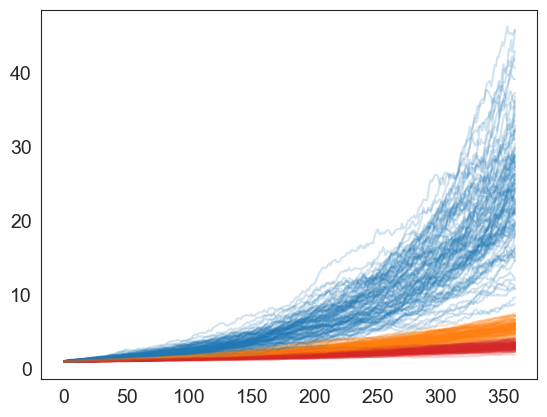

In [687]:
fig, ax = plt.subplots()
for i in range(100):
    returns_df = simulate_returns()
    cum_returns = returns_df.add(1).cumprod()
    cum_returns['Home_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:orange")
    cum_returns['Condo_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:red")
    cum_returns['Stock_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:blue")

In [688]:
def salt_deduction_decision(property_tax):
    """Caps SALT deduction (property + state income tax) at $10,000"""
    return np.minimum(property_tax, 10000)

def itemized_vs_standard_deduction(itemized, standard_deduction=14600):
    """Chooses the better deduction (standard or itemized)"""
    return np.maximum(itemized, standard_deduction)

def apply_compounding(growth, start, deposits):
    growth = np.array(growth)
    deposits = np.array(deposits)
    balance = start
    balances = [start]
    for i in range(len(growth)-1):
        balance = (balance + deposits[i]) * (1 + growth[i])
        balances.append(balance)
    return balances

In [690]:
returns_df = simulate_returns()

In [691]:
def owner_table(interest_rate=0.065, renovation=0, cost=900000, hoa=0, returns_df=returns_df, reno_return=1.1, cg_tax=.15, condo=False):
    down_payment = cost * .2
    principal = cost - down_payment
    buying_fees = principal*.04
    post_reno_value = (cost + renovation * reno_return)

    df_own = pd.DataFrame()
    
    df_own["Period"] =  pd.Series(range(12*30)) + 1
    df_own["Date"] = pd.date_range(start=datetime.today().date(),
                        periods=12*30,
                        freq='MS',
                        name="Date")
    df_own = df_own.set_index('Date')
    is_year = df_own.index.month == 1
    year = is_year.cumsum()
    df_own["Purchase_cost"] = buying_fees + down_payment + renovation
    df_own["Principal_monthly"] = npf.ppmt(interest_rate/12,
                                        df_own["Period"],
                                        12*30,
                                        principal) * -1
    df_own["Interest_monthly"] = npf.ipmt(interest_rate/12,
                                        df_own["Period"],
                                        12*30,
                                        principal) * -1
    df_own['HOA_monthly'] = hoa
    df_own["PropTax_monthly"] = np.round((cost * 1.02**((year)) * 0.0124) / 12, 2)
    annual_proptax = df_own.resample("YE")['PropTax_monthly'].sum().rename("PropTax_annual").reindex(df_own.index, method="bfill")
    df_own = df_own.merge(
        annual_proptax, left_index=True, right_index=True, how="left"
        )
    annual_interest = df_own.resample("YE")['Interest_monthly'].sum().rename("Interest_annual").reindex(df_own.index, method="bfill")
    df_own = df_own.merge(
        annual_interest, left_index=True, right_index=True, how="left"
        )
    df_own['Total_deduction'] = itemized_vs_standard_deduction(
        df_own['Interest_annual'] + df_own["PropTax_annual"].apply(salt_deduction_decision)
        )
    df_own['Tax_Savings_monthly'] = (df_own['Total_deduction'] * 0.24 + df_own['Total_deduction'] * 0.093) / 12
    df_own['Pre_tax_monthly'] = df_own[["Principal_monthly", "Interest_monthly", "PropTax_monthly", "HOA_monthly"]].sum(axis=1)
    df_own['Post_tax_monthly'] = df_own['Pre_tax_monthly'] - df_own['Tax_Savings_monthly']
    df_own["Balance_Remaining"] = principal - df_own["Principal_monthly"].cumsum()
    if condo:
        df_own["Home_Value"] = apply_compounding(growth=returns_df['Condo_Appreciation'],
                                            start=post_reno_value,
                                            deposits=np.zeros_like(returns_df['Condo_Appreciation'])
                                            ) 
    else:
        df_own["Home_Value"] = apply_compounding(growth=returns_df['Home_Appreciation'],
                                                start=post_reno_value,
                                                deposits=np.zeros_like(returns_df['Home_Appreciation'])
                                                ) 
    df_own["Sale_fee"] = df_own["Home_Value"] * .07
    df_own['Gain'] = (df_own["Home_Value"] - cost)
    df_own["Sale_tax"]  = np.maximum(0, (df_own['Gain'] - 500000)) * cg_tax
    df_own['Profit'] = df_own['Gain'] - df_own["Sale_tax"] - df_own["Sale_fee"] - buying_fees
    return df_own

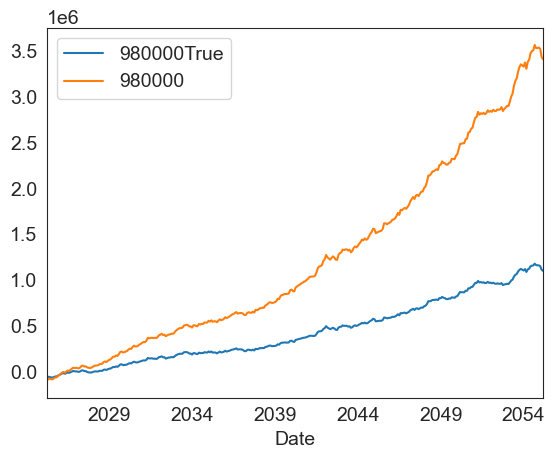

In [692]:
returns_df = simulate_returns()
# No Reno
scenario_1 = {'cost': 980000, 'renovation': 0, 'returns_df': returns_df, 'condo': True}
# Reno
scenario_2 = {'cost': 980000, 'renovation': 0, 'returns_df': returns_df}

def compare(scenario_1, scenario_2, returns_df, verbose=False):
    series_1 = owner_table(**scenario_1)
    series_2 = owner_table(**scenario_2)
    both = [series_1, series_2]
    larger_monthly = np.argmax([s['Post_tax_monthly'].iloc[0] for s in both])
    smaller_monthly = np.argmin([s['Post_tax_monthly'].iloc[0] for s in both])
    if verbose:
        print(scenario_1['cost'])
        print("\tmonthly postax", series_1['Post_tax_monthly'].iloc[0])
        print("\tmonthly pretax", series_1['Pre_tax_monthly'].iloc[0])
        print(scenario_2['cost'])
        print("\tmonthly postax", series_2['Post_tax_monthly'].iloc[0])
        print("\tmonthly pretax", series_2['Pre_tax_monthly'].iloc[0])

    monthly_diff = (both[larger_monthly])['Post_tax_monthly'] - (both[smaller_monthly])['Post_tax_monthly']
    monthly_savings_invested = apply_compounding(returns_df['Stock_Appreciation'],
                                                monthly_diff.iloc[0],
                                                monthly_diff)

    total_cost_1 = series_1['Purchase_cost'].iloc[0]
    total_cost_2 = series_2['Purchase_cost'].iloc[0]
    larger_upfront = np.argmax([s['Purchase_cost'].iloc[0] for s in both])
    smaller_upfront = np.argmin([s['Purchase_cost'].iloc[0] for s in both])
    if verbose:
        print(scenario_1['cost'])
        print("\tupfront cost", total_cost_1)
        print(scenario_2['cost'])
        print("\tupfront cost", total_cost_2)
        print("\tDifference", (max(total_cost_1, total_cost_2) - min(total_cost_1, total_cost_2)))

    upfront_savings_invested = apply_compounding(returns_df['Stock_Appreciation'],
                                                (max(total_cost_1, total_cost_2) - min(total_cost_1, total_cost_2)),
                                                np.zeros_like(returns_df['Stock_Appreciation']))
    both[smaller_upfront]['Profit'] = both[smaller_upfront]['Profit'].add(upfront_savings_invested).multiply(.85)
    both[smaller_monthly]['Profit'] = both[smaller_monthly]['Profit'].add(monthly_savings_invested).multiply(.85)

    final_profit_1 = both[0]['Profit'].iloc[-1]
    final_profit_2 = both[1]['Profit'].iloc[-1]
    if verbose:
        print(scenario_1['cost'])
        print("\tFinal", final_profit_1)
        print(scenario_2['cost'])
        print("\tFinal", final_profit_2) 
    return both 

fig, ax = plt.subplots()
both = compare(scenario_1, scenario_2, returns_df)
both[0]['Profit'].plot(ax=ax, label=str(scenario_1['cost']) + str(scenario_1['condo']))
both[1]['Profit'].plot(ax=ax, label=str(scenario_2['cost']))
ax.legend();

980000
	monthly postax 4417.4729585583755
	monthly pretax 5612.813818490858
1100000
	monthly postax 4964.771040983892
	monthly pretax 6300.096735040759
980000
	upfront cost 257360.0
1100000
	upfront cost 285200.0
	Difference 27840.0
980000
	Final 3673063.577209598
1100000
	Final 4401979.788621668


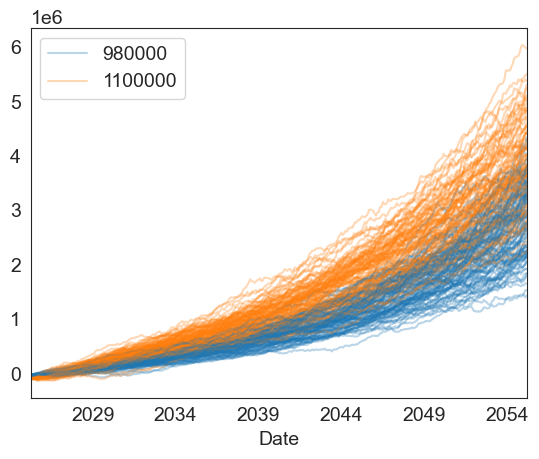

In [937]:
fig, ax = plt.subplots()
profits = {}
yr_10 = {}
ir = 0.058
for i in range(100):
    returns_df = simulate_returns()
    # No Reno
    scenario_1 = {'cost': 980000, 'renovation': 30000, 'returns_df': returns_df, 'condo': True, 'interest_rate':ir}
    # Reno
    scenario_2 = {'cost': 1100000, 'renovation': 30000, 'returns_df': returns_df, 'condo': False, 'interest_rate':ir}
    if i == 0:
        both = compare(scenario_1, scenario_2, returns_df, verbose=True)
        profits[str(scenario_1['cost'])] = []
        profits[str(scenario_2['cost'])] = []
        profits[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[-1])
        profits[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[-1])
        yr_10[str(scenario_1['cost'])] = []
        yr_10[str(scenario_2['cost'])] = []
        yr_10[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[10*12])
        yr_10[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[10*12])
        both[0]['Profit'].plot(ax=ax, label=str(scenario_1['cost']), color="tab:blue", alpha=.3)
        both[1]['Profit'].plot(ax=ax, label=str(scenario_2['cost']), color="tab:orange", alpha=.3)
    else:
       both = compare(scenario_1, scenario_2, returns_df)
       profits[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[-1])
       profits[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[-1])
       yr_10[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[10*12])
       yr_10[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[10*12])
       both[0]['Profit'].plot(ax=ax, label="_k", color="tab:blue", legend=False, alpha=.3)
       both[1]['Profit'].plot(ax=ax, label="_l", color="tab:orange", legend=False, alpha=.3) 
ax.legend();

#### 10 yr

In [938]:
pd.DataFrame(yr_10).describe()

,980000,1100000
count,100.000000,1.000000e+02
mean,403968.242061,6.559004e+05
std,96367.311011,1.454037e+05
min,212736.105034,3.641720e+05
25%,332655.058733,5.401123e+05
50%,412667.156077,6.585328e+05
75%,473397.751868,7.533855e+05
max,641079.680702,1.019030e+06


In [939]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(yr_10).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.584e+05,1.64e+04,40.140,0.000,6.26e+05,6.91e+05
I(variable)[T.980000],-2.457e+05,2.32e+04,-10.594,0.000,-2.91e+05,-2e+05


In [940]:
mod.params.iloc[-1]/10/12

-2047.7854563486683

#### 30 yr

In [941]:
pd.DataFrame(profits).describe()

,980000,1100000
count,1.000000e+02,1.000000e+02
mean,2.850069e+06,3.857486e+06
std,6.440626e+05,7.847869e+05
min,1.436067e+06,2.240759e+06
25%,2.284975e+06,3.290137e+06
50%,2.862969e+06,3.808014e+06
75%,3.359863e+06,4.420590e+06
max,4.344491e+06,5.974344e+06


In [942]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(profits).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.809e+06,1.08e+05,35.190,0.000,3.6e+06,4.02e+06
I(variable)[T.980000],-9.483e+05,1.53e+05,-6.195,0.000,-1.25e+06,-6.46e+05


In [943]:
mod.params.iloc[-1]/30/12

-2634.138894745806

In [588]:
# Buying Table
def owner_table(interest_rate=0.065, renovation=100000, cost=875000, hoa=0, returns_df=returns_df, reno_return=1.1):
       down_payment = cost * .2
       principal = cost - down_payment
       buying_fees = principal*.04
       df_own = pd.DataFrame()
       df_own["Period"] =  pd.Series(range(12*30)) + 1
       df_own["Date"] = pd.date_range(start=datetime.today(),
                            periods=12*30,
                            freq='MS',
                            name="Date")
       
       df_own["Principal_Paid"] = npf.ppmt(interest_rate/12,
                                          df_own["Period"],
                                          12*30,
                                          principal) * -1
       df_own["Interest_Paid"] = npf.ipmt(interest_rate/12,
                                          df_own["Period"],
                                          12*30,
                                          principal) * -1
       df_own["HOA_Paid"] = hoa
       df_own["HOA_Paid_Cum"] = df_own["HOA_Paid"].cumsum()

       df_own["Balance_Remaining"] = principal - df_own["Principal_Paid"].cumsum()
       df_own["Home_Value"] = apply_compounding(returns_df['Home_Appreciation'],
                                               (cost + renovation * reno_return),
                                               np.zeros_like(returns_df['Home_Appreciation']))
       
       df_own["PropTax_Paid_Monthly"] = (cost * 1.024**((year)) * 0.01) / 12
       
       df_own["Sale_Fee"] = df_own["Home_Value"] * .07

       # annual_interest_paid = (df_own['Interest_Paid'].rolling(12).sum() * is_year).fillna(0)
       # annual_prop_tax_deductable = (df_own["PropTax_Paid_Monthly"].rolling(12).sum() * is_year).apply(salt_deduction_decision)
       # tax_savings = ((annual_prop_tax_deductable + annual_interest_paid) * .24 + (annual_interest_paid + annual_prop_tax_deductable) * .093).apply(standard_deduction_decision) / 12

       # Apply SALT cap (assuming no state income tax for now, update if needed)
       monthly_salt_deduction = df_own["PropTax_Paid_Monthly"].apply(lambda x: salt_deduction_decision(x*12))

       # Compute itemized deduction (interest + SALT deduction)
       annual_itemized_deduction = df_own['Interest_Paid']*12 + monthly_salt_deduction

       # Choose between standard or itemized deduction
       final_deduction = annual_itemized_deduction.apply(lambda x: itemized_vs_standard_deduction(x))

       # Step 5: Compute tax savings
       # Assume 24% federal, 9.3% CA tax, but **only applied to itemized deductions** above standard
       df_own['Tax_Savings'] = (final_deduction * 0.24 + final_deduction * 0.093)
       df_own["Own_Profit"] = (df_own["Home_Value"] +
                            df_own['Tax_Savings'].cumsum() -
                            df_own["HOA_Paid_Cum"] -
                            df_own["Balance_Remaining"] -
                            (buying_fees + df_own["Sale_Fee"]) -
                            df_own["PropTax_Paid_Monthly"] - df_own["Interest_Paid"].cumsum()
                            )
       df_own["Monthly_cost_pre_tax"] = (df_own["Principal_Paid"] + df_own["Interest_Paid"] + df_own["HOA_Paid"] + df_own["PropTax_Paid_Monthly"])
       df_own["Monthly_cost_post_tax"] = (df_own["Principal_Paid"] + df_own["Interest_Paid"] + df_own["HOA_Paid"] + df_own["PropTax_Paid_Monthly"] - df_own['Tax_Savings'])
       df_own["Upfront_cost"] = buying_fees + down_payment + renovation
       df_own = round(df_own, 2)
       return df_own

monthly postax {'cost': 900000, 'renovation': 100000} -13280.51
monthly postax {'cost': 1100000, 'renovation': 10000} -15898.73
monthly pretax {'cost': 900000, 'renovation': 100000} 5300.89
monthly pretax {'cost': 1100000, 'renovation': 10000} 6478.87
upfront {'cost': 900000, 'renovation': 100000} 308800.0
upfront {'cost': 1100000, 'renovation': 10000} 265200.0
43600.0
1 0
No Reno Final 4828368.724774251
Reno Final 9007987.118080435


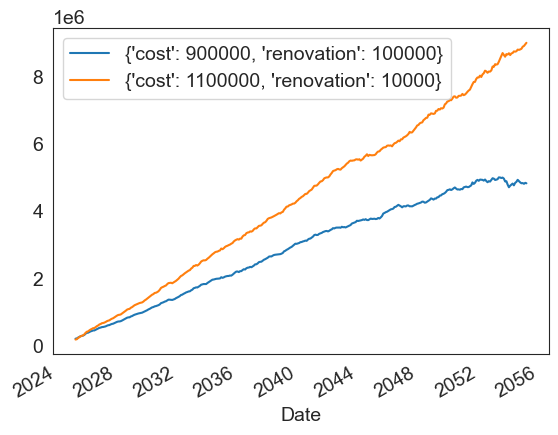

In [589]:
# No Reno
scenario_1 = {'cost': 900000, 'renovation': 100000}
# Reno
scenario_2 = {'cost': 1100000, 'renovation': 10000}
series_1 = owner_table(**scenario_1)
series_2 = owner_table(**scenario_2)
both = [series_1, series_2]
larger_monthly = np.argmax([s['Monthly_cost_pre_tax'].iloc[0] for s in both])
smaller_monthly = np.argmin([s['Monthly_cost_pre_tax'].iloc[0] for s in both])

print(f"monthly postax {scenario_1}", series_1['Monthly_cost_post_tax'].iloc[0])
print(f"monthly postax {scenario_2}", series_2['Monthly_cost_post_tax'].iloc[0])
print(f"monthly pretax {scenario_1}", series_1['Monthly_cost_pre_tax'].iloc[0])
print(f"monthly pretax {scenario_2}", series_2['Monthly_cost_pre_tax'].iloc[0])

monthly_savings_invested = apply_compunding(returns_df['Stock_Appreciation'],
                                               0,
                                               (both[larger_monthly])['Monthly_cost_post_tax'] -
                                               (both[smaller_monthly])['Monthly_cost_post_tax']).values

total_cost_1 = series_1['Upfront_cost'][0]
total_cost_2 = series_2['Upfront_cost'][0]
larger_upfront = np.argmax([s['Upfront_cost'][0] for s in both])
smaller_upfront = np.argmin([s['Upfront_cost'][0] for s in both])
print(f"upfront {scenario_1}", total_cost_1)
print(f"upfront {scenario_2}", total_cost_2)
print((max(total_cost_1, total_cost_2) - min(total_cost_1, total_cost_2)))

upfront_savings_invested = apply_compunding(returns_df['Stock_Appreciation'],
                                               (max(total_cost_1, total_cost_2) - min(total_cost_1, total_cost_2)),
                                               np.zeros_like(returns_df['Stock_Appreciation'])).values
fig, ax = plt.subplots()

print(smaller_upfront, smaller_monthly)
both[smaller_upfront]['Own_Profit'] = both[smaller_upfront]['Own_Profit'].add(upfront_savings_invested)
both[smaller_monthly]['Own_Profit'] = both[smaller_monthly]['Own_Profit'].add(monthly_savings_invested)

final_profit_1 = both[0]['Own_Profit'].iloc[-1]
final_profit_2 = both[1]['Own_Profit'].iloc[-1]
print("No Reno Final", final_profit_1)
print("Reno Final", final_profit_2)
both[0].set_index("Date")['Own_Profit'].plot(ax=ax, label=f"{scenario_1}")
both[1].set_index("Date")['Own_Profit'].plot(ax=ax, label=f"{scenario_2}")
ax.legend();

In [100]:
both[smaller_upfront].loc[:, 'Own_Profit']


0       114276.95
1       114202.88
2       121062.18
3       144540.18
4       164444.25
          ...    
355    5641786.66
356    5644429.29
357    5679346.62
358    5720788.67
359    5775002.67
Name: Own_Profit, Length: 360, dtype: float64

In [95]:
both[larger_upfront]

,Period,Date,Principal_Paid,Interest_Paid,HOA_Paid,Balance_Remaining,Home_Value,PropTax_Paid_Monthly,Sale_Fee,Tax_Savings,Own_Profit,Monthly_cost_pre_tax,Monthly_cost_post_tax,Upfront_cost
0,1,2025-03-01 14:42:22.992481,723.21,4333.33,0,799276.79,1105000.00,833.33,77350.00,1720.50,192927.04,5889.88,4169.38,332000.0
1,2,2025-04-01 14:42:22.992481,727.13,4329.42,0,798549.66,1107219.05,833.33,77505.33,1719.20,193107.67,5889.88,4170.68,332000.0
2,3,2025-05-01 14:42:22.992481,731.07,4325.48,0,797818.59,1116295.33,833.33,78140.67,1717.88,199672.08,5889.88,4171.99,332000.0
3,4,2025-06-01 14:42:22.992481,735.03,4321.52,0,797083.57,1141818.65,833.33,79927.31,1716.57,221538.85,5889.88,4173.31,332000.0
4,5,2025-07-01 14:42:22.992481,739.01,4317.54,0,796344.56,1163795.41,833.33,81465.68,1715.24,240113.94,5889.88,4174.64,332000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,356,2054-10-01 14:42:22.992481,4921.79,134.75,0,19955.22,6360197.13,1657.74,445213.80,405.15,5280199.77,6714.29,6309.14,332000.0
356,357,2054-11-01 14:42:22.992481,4948.45,108.09,0,15006.77,6356661.37,1657.74,444966.30,405.15,5282157.03,6714.29,6309.14,332000.0
357,358,2054-12-01 14:42:22.992481,4975.26,81.29,0,10031.51,6385018.50,1657.74,446951.30,405.15,5313828.28,6714.29,6309.14,332000.0
358,359,2055-01-01 14:42:22.992481,5002.21,54.34,0,5029.30,6419772.00,1657.74,449384.04,405.15,5351502.05,6714.29,6309.14,332000.0


In [92]:
upfront_savings_invested

0      5.360000e+04
1      5.242068e+04
2      5.386966e+04
3      5.440309e+04
4      5.571523e+04
           ...     
355    1.306750e+06
356    1.278085e+06
357    1.248000e+06
358    1.229988e+06
359    1.220342e+06
Length: 360, dtype: float64

In [90]:
both[0]

,Period,Date,Principal_Paid,Interest_Paid,HOA_Paid,Balance_Remaining,Home_Value,PropTax_Paid_Monthly,Sale_Fee,Tax_Savings,Own_Profit,Monthly_cost_pre_tax,Monthly_cost_post_tax,Upfront_cost
0,1,2025-03-01 14:40:17.273414,867.85,5200.00,0,959132.15,1200000.00,1000.00,84000.00,2009.10,114276.95,7067.85,5058.75,278400.0
1,2,2025-04-01 14:40:17.273414,872.55,5195.30,0,958259.59,1202409.83,1000.00,84168.69,2007.53,114202.88,7067.85,5060.32,278400.0
2,3,2025-05-01 14:40:17.273414,877.28,5190.57,0,957382.31,1212266.42,1000.00,84858.65,2005.96,121062.18,7067.85,5061.89,278400.0
3,4,2025-06-01 14:40:17.273414,882.03,5185.82,0,956500.28,1239984.06,1000.00,86798.88,2004.38,144540.18,7067.85,5063.47,278400.0
4,5,2025-07-01 14:40:17.273414,886.81,5181.04,0,955613.47,1263850.21,1000.00,88469.51,2002.79,164444.25,7067.85,5065.07,278400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,356,2054-10-01 14:40:17.273414,5906.15,161.70,0,23946.26,6907001.40,1989.29,483490.10,405.15,5641786.66,8057.15,7652.00,278400.0
356,357,2054-11-01 14:40:17.273414,5938.14,129.71,0,18008.12,6903161.67,1989.29,483221.32,405.15,5644429.29,8057.15,7652.00,278400.0
357,358,2054-12-01 14:40:17.273414,5970.31,97.54,0,12037.81,6933956.75,1989.29,485376.97,405.15,5679346.62,8057.15,7652.00,278400.0
358,359,2055-01-01 14:40:17.273414,6002.65,65.20,0,6035.16,6971698.10,1989.29,488018.87,405.15,5720788.67,8057.15,7652.00,278400.0


In [86]:
both[smaller_upfront]

,Period,Date,Principal_Paid,Interest_Paid,HOA_Paid,Balance_Remaining,Home_Value,PropTax_Paid_Monthly,Sale_Fee,Tax_Savings,Own_Profit,Monthly_cost_pre_tax,Monthly_cost_post_tax,Upfront_cost
0,1,2025-03-01 14:38:09.322372,867.85,5200.00,0,959132.15,1200000.00,1000.00,84000.00,2009.10,1.678770e+05,7067.85,5058.75,278400.0
1,2,2025-04-01 14:38:09.322372,872.55,5195.30,0,958259.59,1202409.83,1000.00,84168.69,2007.53,1.666236e+05,7067.85,5060.32,278400.0
2,3,2025-05-01 14:38:09.322372,877.28,5190.57,0,957382.31,1212266.42,1000.00,84858.65,2005.96,1.749318e+05,7067.85,5061.89,278400.0
3,4,2025-06-01 14:38:09.322372,882.03,5185.82,0,956500.28,1239984.06,1000.00,86798.88,2004.38,1.989433e+05,7067.85,5063.47,278400.0
4,5,2025-07-01 14:38:09.322372,886.81,5181.04,0,955613.47,1263850.21,1000.00,88469.51,2002.79,2.201595e+05,7067.85,5065.07,278400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,356,2054-10-01 14:38:09.322372,5906.15,161.70,0,23946.26,6907001.40,1989.29,483490.10,405.15,6.948537e+06,8057.15,7652.00,278400.0
356,357,2054-11-01 14:38:09.322372,5938.14,129.71,0,18008.12,6903161.67,1989.29,483221.32,405.15,6.922514e+06,8057.15,7652.00,278400.0
357,358,2054-12-01 14:38:09.322372,5970.31,97.54,0,12037.81,6933956.75,1989.29,485376.97,405.15,6.927346e+06,8057.15,7652.00,278400.0
358,359,2055-01-01 14:38:09.322372,6002.65,65.20,0,6035.16,6971698.10,1989.29,488018.87,405.15,6.950777e+06,8057.15,7652.00,278400.0


In [18]:
upfront_savings_invested

0      7.559760e+04
1      7.393428e+04
2      7.597792e+04
3      7.673028e+04
4      7.858093e+04
           ...     
355    1.843044e+06
356    1.802615e+06
357    1.760182e+06
358    1.734779e+06
359    1.721174e+06
Length: 360, dtype: float64

In [19]:
results_df = pd.DataFrame()
results_df['no_reno'] = owner_table(**scenario_1)['Own_Profit'].add(upfront_savings_invested)
results_df['reno'] = owner_table(**scenario_2)['Own_Profit'].add(monthly_savings_invested)
results_df['diff'] = results_df['reno'] - results_df['no_reno']
results_df

,no_reno,reno,diff
0,1.894660e+05,2.368174e+05,4.735136e+04
1,1.877299e+05,2.384728e+05,5.074292e+04
2,1.966093e+05,2.462432e+05,4.963393e+04
3,2.207565e+05,2.683815e+05,4.762501e+04
4,2.424409e+05,2.875164e+05,4.507545e+04
...,...,...,...
355,7.465185e+06,9.250726e+06,1.785541e+06
356,7.427390e+06,9.161574e+06,1.734184e+06
357,7.419751e+06,9.095737e+06,1.675986e+06
358,7.435643e+06,9.074621e+06,1.638978e+06


In [20]:
owner_table(cost=875000, renovation=100000)

,Period,Date,Principal_Paid,Interest_Paid,HOA_Paid,Balance_Remaining,Home_Value,PropTax_Paid_Monthly,Sale_Fee,Tax_Savings,Own_Profit,Monthly_cost_pre_tax,Monthly_cost_post_tax,Upfront_cost
0,1,2025-03-01 19:48:54.681614,632.81,3791.67,0,699367.19,985000.00,729.17,68950.00,1505.44,185667.41,5153.64,3648.21,303000.0
1,2,2025-04-01 19:48:54.681614,636.24,3788.24,0,698730.95,986978.07,729.17,69088.46,1504.30,185859.31,5153.64,3649.35,303000.0
2,3,2025-05-01 19:48:54.681614,639.68,3784.79,0,698091.27,995068.68,729.17,69654.81,1503.15,191741.62,5153.64,3650.49,303000.0
3,4,2025-06-01 19:48:54.681614,643.15,3781.33,0,697448.12,1017820.25,729.17,71247.42,1501.99,211264.39,5153.64,3651.65,303000.0
4,5,2025-07-01 19:48:54.681614,646.63,3777.84,0,696801.49,1037410.38,729.17,72618.73,1500.83,227852.84,5153.64,3652.81,303000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,356,2054-10-01 19:48:54.681614,4306.57,117.91,0,17460.82,5669496.99,1294.89,396864.79,405.15,4728230.80,5719.36,5314.22,303000.0
356,357,2054-11-01 19:48:54.681614,4329.90,94.58,0,13130.92,5666345.20,1294.89,396644.16,405.15,4729940.10,5719.36,5314.22,303000.0
357,358,2054-12-01 19:48:54.681614,4353.35,71.13,0,8777.57,5691622.83,1294.89,398413.60,405.15,4758135.67,5719.36,5314.22,303000.0
358,359,2055-01-01 19:48:54.681614,4376.93,47.55,0,4400.64,5722602.19,1294.89,400582.15,405.15,4791681.01,5719.36,5314.22,303000.0


In [21]:
owner_table(cost=1100000, renovation=0)

,Period,Date,Principal_Paid,Interest_Paid,HOA_Paid,Balance_Remaining,Home_Value,PropTax_Paid_Monthly,Sale_Fee,Tax_Savings,Own_Profit,Monthly_cost_pre_tax,Monthly_cost_post_tax,Upfront_cost
0,1,2025-03-01 19:48:54.841272,795.53,4766.67,0,879204.47,1100000.00,916.67,77000.00,1864.80,104777.00,6478.87,4614.07,255200.0
1,2,2025-04-01 19:48:54.841272,799.84,4762.36,0,878404.63,1102209.01,916.67,77154.63,1863.37,104732.23,6478.87,4615.50,255200.0
2,3,2025-05-01 19:48:54.841272,804.17,4758.03,0,877600.45,1111244.22,916.67,77787.10,1861.92,111043.04,6478.87,4616.94,255200.0
3,4,2025-06-01 19:48:54.841272,808.53,4753.67,0,876791.92,1136652.05,916.67,79565.64,1860.47,132587.66,6478.87,4618.39,255200.0
4,5,2025-07-01 19:48:54.841272,812.91,4749.29,0,875979.01,1158529.36,916.67,81097.06,1859.01,150856.19,6478.87,4619.85,255200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,356,2054-10-01 19:48:54.841272,5413.97,148.23,0,21950.74,6331417.95,1627.86,443199.26,405.15,5180153.07,7190.06,6784.91,255200.0
356,357,2054-11-01 19:48:54.841272,5443.30,118.90,0,16507.44,6327898.19,1627.86,442952.87,405.15,5182609.24,7190.06,6784.91,255200.0
357,358,2054-12-01 19:48:54.841272,5472.78,89.42,0,11034.66,6356127.02,1627.86,444928.89,405.15,5214650.56,7190.06,6784.91,255200.0
358,359,2055-01-01 19:48:54.841272,5502.43,59.77,0,5532.23,6390723.25,1627.86,447350.63,405.15,5252672.86,7190.06,6784.91,255200.0


Note this code, which is a bit of a monster:

In [22]:
df_own = owner_table()

In [23]:
df_own["PropTax_Paid"] = (df_own["Period"]
                          .apply(lambda x:
                                 (cost * 1.02**((x-1)/12) * 0.01)
                                 if (x-1) in list(range(0, 12*1000, 12))
                                 else 0)
                          .cumsum())

What is happening here is a calculation of property assessed value and property tax according to California's property assessment/tax regime ([more here)](https://www.boe.ca.gov/proptaxes/pdf/pub29.pdf). We'll look at this in two pieces, first, assessed value. In California, once you purchase a property, its assessed value is set at the purchase price, then increases annually by the lower of 2% or the rate of inflation according to the California Consumer Price Index (CCPI). You could write out an equation for this as follows:  

$$
\begin{align*}
AnnualFactor_y =
\begin{cases}
        1 + CCPI_y, & \text{if } CCPI_y < 0.02 \\\
        1.02, & \text{otherwise}
\end{cases}
\end{align*}
$$

$AnnualFactor$ is the amount that the assessed value of a home will appreciate (expressed as a multiplier) in a given year, $y$. We define $y^*$ as the year of initial purchase and 
$PurchasePrice$ as the amount that the home was purchased for. Given that, $AssessedValue$ is defined as follows:

$$ \begin{align*}
AssessedValue_y =
    \begin{cases}
        PurchasePrice, & \text{if } y = y^* \\
        AssessedValue_{y-1} \times AnnualFactor_y, & \text{otherwise }
    \end{cases}
\end{align*}
$$

In our code, we will simplify this calculation by excluding the CCPI and just always using 1.02 as our annual factor. Therefore, we get:

$$
  AssessedValue_y = PurchasePrice \times 1.02^y
$$

and once we factor in taxes (1%), we get:  

$$
  PropertyTax_y = 0.01(PurchasePrice \times 1.02^y)
$$

and finally we look at the the cumulative total property tax you've paid in a given year $y$, which is `df_own["PropTax_Paid"] `:  

$$
\begin{equation*}
  PropertyTaxPaid_y = \sum_{y=1}^{30} 0.01(PurchasePrice \times 1.02^y)
\end{equation*}
$$

There's some elements added to the code to work between years and months, but that equation is the gist of it.  
We end up with the following table for property ownership:


### Rental Table
This one is a but more simple, only examining the total rent you've paid in a given month and simulated stock returns at that point.


In [24]:
# Rental Table
df_rent = pd.DataFrame()
df_rent["Period"] =  pd.Series(range(12*30)) + 1
df_rent["Date"] = pd.date_range(start=datetime.today(),
                           periods=12*30,
                           freq='MS',
                           name="Date")

df_rent["Rent"] = rent * (rent_growth)**(year)
df_rent["Rent_Savings"] = (df_own[['Principal_Paid', 'Interest_Paid']].sum(axis=1) * -1 - df_rent["Rent"])

savings = [(cost*.2 + buying_fees + renovation)]
for i in range(len(returns_df['Stock_Appreciation'])-1):
    savings.append( (savings[i] + df_rent["Rent_Savings"][i]) * returns_df['Stock_Appreciation'].add(1)[i] )

df_rent["Savings_Invested"] =  savings

df_rent["Rent_Paid"] = df_rent["Rent"].cumsum()
rent_tax_savings = ((14600 * is_year) / 12).cumsum()
df_rent["Rent_Profit"] = df_rent["Savings_Invested"] - df_rent["Rent_Paid"] + rent_tax_savings
df_rent = round(df_rent, 2)

In [25]:
df_rent["Rent_Savings"]

0     -7924.48
1     -7924.48
2     -7924.47
3     -7924.48
4     -7924.47
        ...   
355   -9814.41
356   -9814.41
357   -9814.41
358   -9814.41
359   -9814.41
Name: Rent_Savings, Length: 360, dtype: float64

In [26]:
df_rent

,Period,Date,Rent,Rent_Savings,Savings_Invested,Rent_Paid,Rent_Profit
0,1,2025-03-01 19:48:55.160726,3500.00,-7924.48,303000.00,3500.00,300716.67
1,2,2025-04-01 19:48:55.160726,3500.00,-7924.48,288583.17,7000.00,282799.84
2,3,2025-05-01 19:48:55.160726,3500.00,-7924.47,288416.49,10500.00,279133.15
3,4,2025-06-01 19:48:55.160726,3500.00,-7924.48,283269.54,14000.00,270486.20
4,5,2025-07-01 19:48:55.160726,3500.00,-7924.47,281986.08,17500.00,265702.75
...,...,...,...,...,...,...,...
355,356,2054-10-01 19:48:55.160726,5389.93,-9814.41,-15757358.42,1555064.89,-17275923.31
356,357,2054-11-01 19:48:55.160726,5389.93,-9814.41,-15421302.68,1560454.82,-16945257.50
357,358,2054-12-01 19:48:55.160726,5389.93,-9814.41,-15067876.03,1565844.75,-16597220.79
358,359,2055-01-01 19:48:55.160726,5389.93,-9814.41,-14860083.40,1571234.69,-16394818.09


## Results
At this point, I'll merge the ownership and rental tables and plot out what happened in this simulation


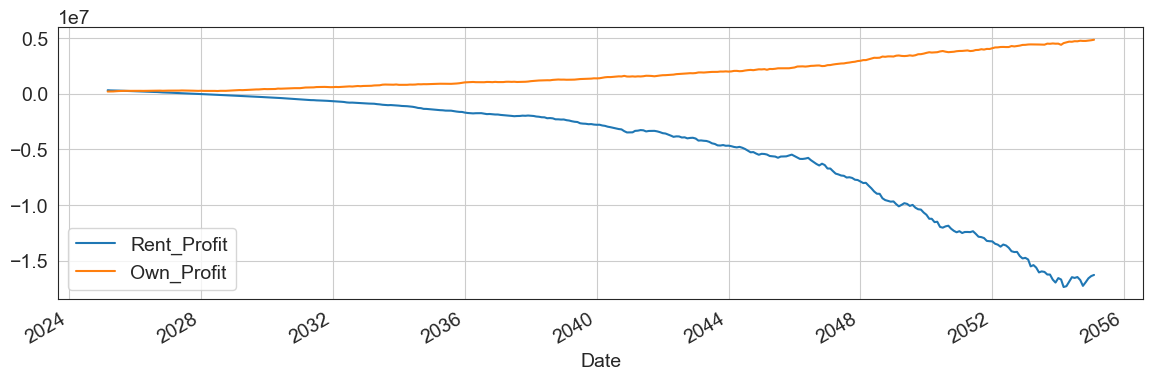

In [27]:
fig, ax = plt.subplots(figsize=(14, 4))
time = 30*12
df_rent.set_index("Date")['Rent_Profit'].head(time).plot(ax=ax)
df_own.set_index("Date")['Own_Profit'].head(time).plot(ax=ax)
ax.grid()
ax.legend()

In [28]:
merged = pd.merge(df_own, df_rent, on="Period")
merged = merged.melt(value_vars = ["Rent_Profit", "Own_Profit"], id_vars='Period')

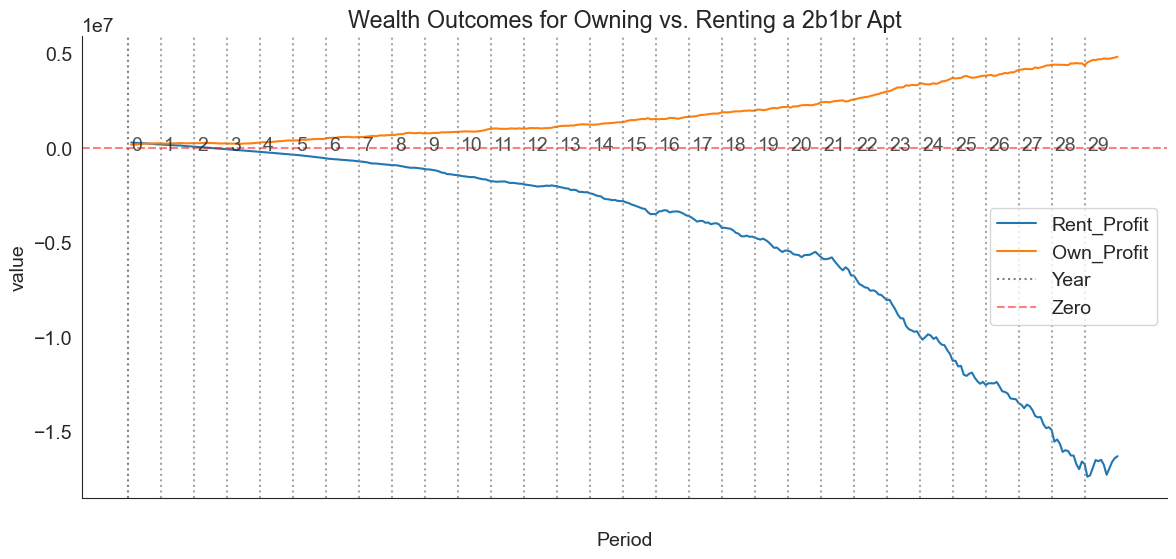

In [29]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title("Wealth Outcomes for Owning vs. Renting a 2b1br Apt")
sns.lineplot(data=merged, x="Period", y="value", hue="variable", ax=ax)
for x in range(0, 350, 12):
    if x == 0:
        ax.axvline(x, color="grey", linestyle=":", alpha=1, label="Year")
    else:
        ax.axvline(x, color="grey", linestyle=":", alpha=0.7)
    ax.text(x+1, -100000, str(int(x/12)), alpha=0.8)
ax.axhline(0, color="red", linestyle="--", alpha=0.5, label="Zero")
ax.xaxis.set_tick_params(labelcolor='none')
ax.legend()
sns.despine()

We can quickly see that ownership will clearly build more wealth in the medium and long run:


In [30]:
years = 5
print(f"Owner after {years} years:", df_own.loc[12*years-1, "Own_Profit"])
print(f"Renter after {years} years:", df_rent.loc[12*years-1, "Rent_Profit"])

Owner after 5 years: 401933.32
Renter after 5 years: -348526.8


However, we can see that, in the unlikely case that the home is sold within the first year or so, it's the renter that has more wealth, likely due to the owner contending with buying/selling fees:


In [31]:
years = 1
print(f"Owner after {years} years:", df_own.loc[12*years-1, "Own_Profit"])
print(f"Renter after {years} years:", df_rent.loc[12*years-1, "Rent_Profit"])

Owner after 1 years: 247760.32
Renter after 1 years: 187418.71


A possible takeaway here is that, as long as you can be confident you'll be able to hold onto the house for more than a year, it's probably better to purchase it. Uncertainty estimates would be useful here, and could be obtained by running the simulation under a wide variety of randomly generated market conditions.